# Importing Libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import graphviz

# Read dataset

Read and learn about Nursery datasets through:
- Website: https://archive.ics.uci.edu/dataset/76/nursery
- File 'nursery.c45-names' : contains information about names, values of attributes and of 'class'

In [21]:
# Read data from csv file
nursery_data = pd.read_csv('nursery.data.csv')

# Rename columns according to the description in 'nursery.c45-names'
nursery_data.columns = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']
nursery_data.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom


In [22]:
nursery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12959 entries, 0 to 12958
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   parents   12959 non-null  object
 1   has_nurs  12959 non-null  object
 2   form      12959 non-null  object
 3   children  12959 non-null  object
 4   housing   12959 non-null  object
 5   finance   12959 non-null  object
 6   social    12959 non-null  object
 7   health    12959 non-null  object
 8   class     12959 non-null  object
dtypes: object(9)
memory usage: 911.3+ KB


In [23]:
nursery_data.describe()

,parents,has_nurs,form,children,housing,finance,social,health,class
count,12959,12959,12959,12959,12959,12959,12959,12959,12959
unique,3,5,4,4,3,2,3,3,5
top,pretentious,less_proper,completed,2,less_conv,inconv,slightly_prob,priority,not_recom
freq,4320,2592,3240,3240,4320,6480,4320,4320,4320


In [24]:
nursery_data['class'].value_counts()

class
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        1
Name: count, dtype: int64

# The main functions fulfill the requirements of the exercise

These functions are written according to each requirement of the exercise, each function corresponds to a requirement, more specifically will be explained in the report.

In [35]:
def prepare_datasets(nursery_data: pd.DataFrame, proportions: list):
    splited_data = []
    # Make a copy of the original data to avoid modifying it
    temp_data = nursery_data.copy()
    for train_prop, test_prop in proportions:
        # Shuffle the data before splitting
        temp_data = temp_data.sample(frac=1)

        features = temp_data.drop('class', axis=1)
        labels = temp_data['class']

        # Split the data into training and test sets with the given proportions
        feature_train, feature_test, label_train, label_test = train_test_split(
            features, labels, train_size=train_prop, test_size=test_prop, random_state=42)

        # Append the split data to the list
        splited_data.append(
            (feature_train, feature_test, label_train, label_test))
    return splited_data


def visualize_distribution_of_classes(nursery_data: pd.DataFrame, splited_data: list, proportions: list):
    temp_data = nursery_data.copy()
    labels = temp_data['class']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for index, (train_prop, test_prop) in enumerate(proportions):
        feature_train, feature_test, label_train, label_test = splited_data[index]

        # Class distribution in the original dataset
        original_class_counts = labels.value_counts()

        # Class distribution in training and test sets
        train_class_counts = label_train.value_counts()
        test_class_counts = label_test.value_counts()

        # Create DataFrames for class distribution visualization
        original_df = pd.DataFrame({"Class": original_class_counts.index,
                                   "Count": original_class_counts.values, "Dataset": "Original"})
        train_df = pd.DataFrame({"Class": train_class_counts.index,
                                "Count": train_class_counts.values, "Dataset": "Training"})
        test_df = pd.DataFrame({"Class": test_class_counts.index,
                               "Count": test_class_counts.values, "Dataset": "Test"})
        class_distribution = pd.concat([original_df, train_df, test_df])

        # Plot class distributions using Seaborn
        sns.set_palette("pastel")
        sns.set_context("notebook", rc={"axes.labelsize": 12})
        sns.set_style("whitegrid")
        ax = sns.barplot(x="Class", y="Count", hue="Dataset",
                         data=class_distribution, ax=axes[index])

        ax.set_title(
            f"Class Distributions\n(Train: {int(train_prop*100)}% / Test: {int(test_prop*100)}%)")
        ax.set_xlabel("Class")
        ax.set_ylabel("Count")
        ax.set_xticklabels(ax.get_xticklabels())
        ax.legend(title="Dataset")

    plt.tight_layout()
    plt.show()


def build_and_evaluate_decision_tree(nursery_data: pd.DataFrame, splited_data: list, proportions: list):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (train_prop, test_prop) in enumerate(proportions):
        feature_train, feature_test, label_train, label_test = splited_data[idx]

        # Label encoding

        feature_train = feature_train.apply(LabelEncoder().fit_transform)
        feature_test = feature_test.apply(LabelEncoder().fit_transform)

        # Create and fit the decision tree model
        decisionTreeClassifier = DecisionTreeClassifier(
            criterion='entropy', random_state=42)
        decisionTreeClassifier.fit(feature_train, label_train)

        # Visualize resulting decision tree using graphviz
        dot_data = export_graphviz(decisionTreeClassifier, out_file=None, feature_names=feature_train.columns,
                                   class_names=nursery_data['class'].unique(), filled=True, rounded=True, special_characters=True)
        graph = graphviz.Source(dot_data)
        graph.render(
            f"decisiontree_image/DecisionTree_train{int(train_prop*100)}_test{int(test_prop*100)}")

        # Predict and report using classification_report
        y_pred = decisionTreeClassifier.predict(feature_test)
        print(f"Train: {int(train_prop*100)}% / Test: {int(test_prop*100)}%")

        print(classification_report(label_test, y_pred, zero_division=0,
              labels=label_test.unique()))
        # Confusion matrix
        cm = confusion_matrix(label_test, y_pred,
                              labels=nursery_data['class'].unique())

        # Plot confusion matrix using Seaborn
        
        sns.set_palette("pastel")
        sns.set_context("notebook", rc={"axes.labelsize": 12})
        sns.set_style("whitegrid")
        ax = sns.heatmap(cm, annot=True, fmt="d", ax=axes[idx])
        ax.set_title(
            f"Confusion Matrix\n(Train: {int(train_prop*100)}% / Test: {int(test_prop*100)}%)")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticklabels(nursery_data['class'].unique())
        ax.set_yticklabels(nursery_data['class'].unique(), rotation=0)

    plt.tight_layout()
    plt.show()


def evaluate_depths_of_decision_tree(dataset):
    max_depths = [None, 2, 3, 4, 5, 6, 7]
    feature_train, feature_test, label_train, label_test = dataset
    accuracy_scores = []
    for depth in max_depths:

        # Label encoding
        feature_train = feature_train.apply(LabelEncoder().fit_transform)
        feature_test = feature_test.apply(LabelEncoder().fit_transform)

        # Create and fit the decision tree model
        decisionTree = DecisionTreeClassifier(
            criterion='entropy',  max_depth=depth, random_state=42)
        decisionTree.fit(feature_train, label_train)

        # Visualize resulting decision tree using graphviz
        dot_data = export_graphviz(decisionTree, out_file=None, feature_names=feature_train.columns,
                                   class_names=nursery_data['class'].unique(), filled=True, rounded=True, special_characters=True)
        graph = graphviz.Source(dot_data)
        graph.render(f"decisiontree_image/DecisionTree_depth{depth}")

        # Accuracy score
        y_pred = decisionTree.predict(feature_test)
        print(
            f"Max depth: {depth} Accuracy score: {accuracy_score(label_test, y_pred)}")
        accuracy_scores.append(accuracy_score(label_test, y_pred))
    # Plot accuracy scores
    sns.set_palette("pastel")
    sns.set_context("notebook", rc={"axes.labelsize": 12})
    sns.set_style("whitegrid")
    ax = sns.lineplot(x=max_depths, y=accuracy_scores)
    ax.set_title("Accuracy Scores")
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Accuracy Score")
    plt.show()

# Assignment requirements

## Preparing the data sets

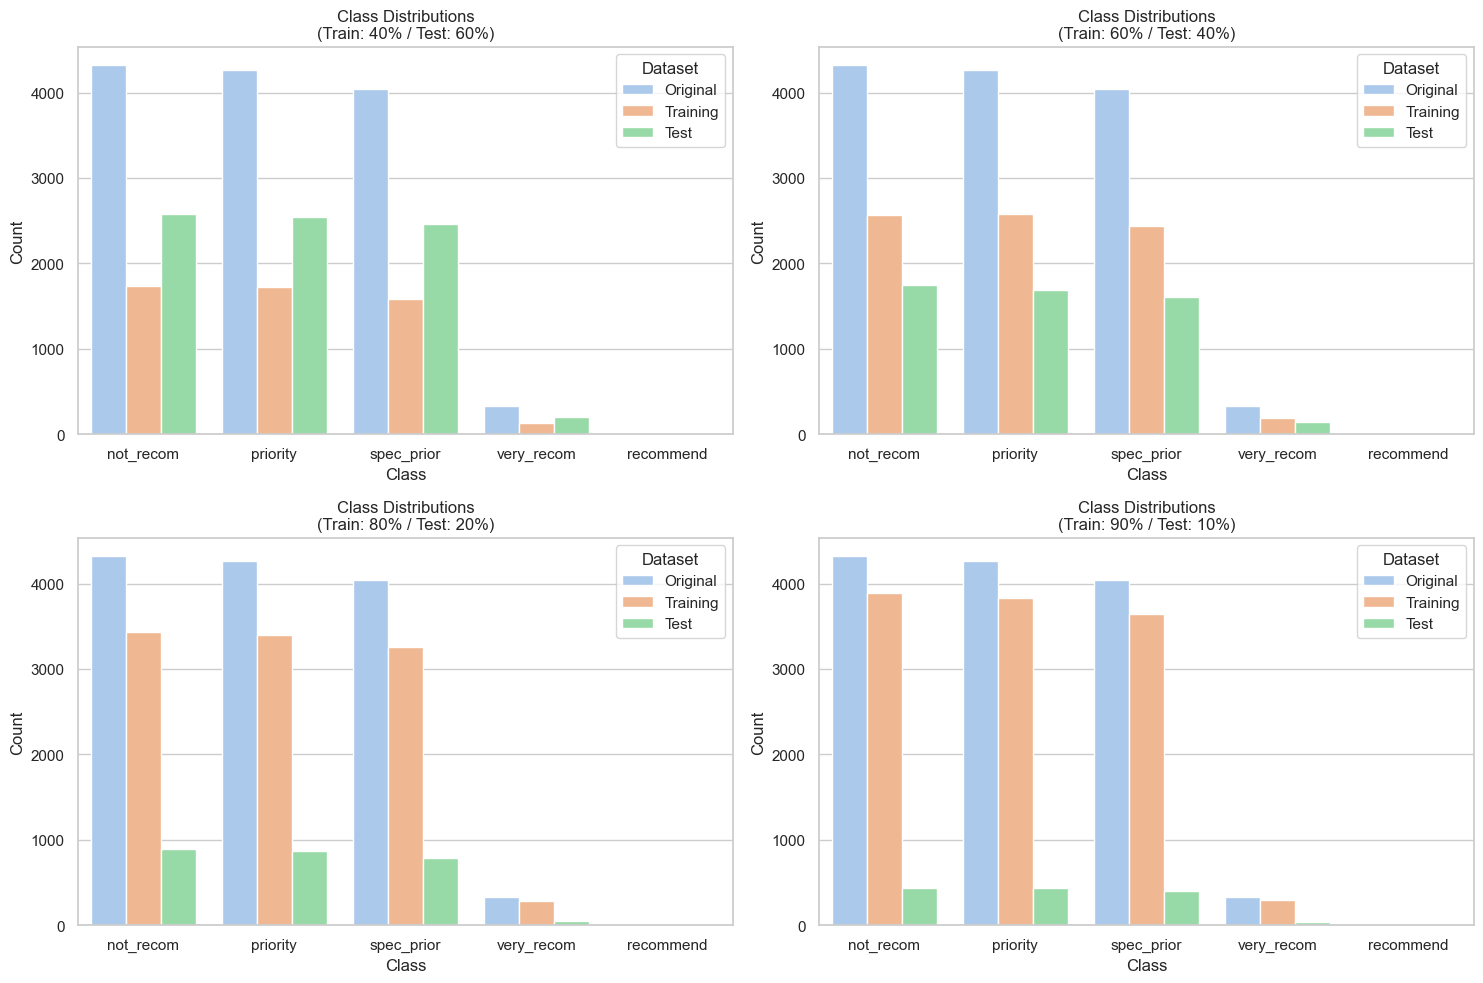

In [26]:
proportions = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]

# Split data into 16 datasets with different proportions
splited_data = prepare_datasets(nursery_data, proportions)

# Visualize distribution of classes  all the data sets (the original set, training set, and test set) of all proportions
visualize_distribution_of_classes(nursery_data, splited_data, proportions)


## Building and evaluating the decision classifier

Train: 40% / Test: 60%
              precision    recall  f1-score   support

  spec_prior       0.98      0.97      0.98      2457
   not_recom       1.00      1.00      1.00      2581
    priority       0.97      0.97      0.97      2542
  very_recom       0.91      0.87      0.89       195
   recommend       0.00      0.00      0.00         1

    accuracy                           0.98      7776
   macro avg       0.77      0.76      0.77      7776
weighted avg       0.98      0.98      0.98      7776

Train: 60% / Test: 40%
              precision    recall  f1-score   support

    priority       0.99      0.99      0.99      1689
   not_recom       1.00      1.00      1.00      1748
  spec_prior       1.00      0.99      0.99      1609
  very_recom       0.95      0.91      0.93       137
   recommend       0.00      0.00      0.00         1

    accuracy                           0.99      5184
   macro avg       0.79      0.78      0.78      5184
weighted avg       0.99      0.

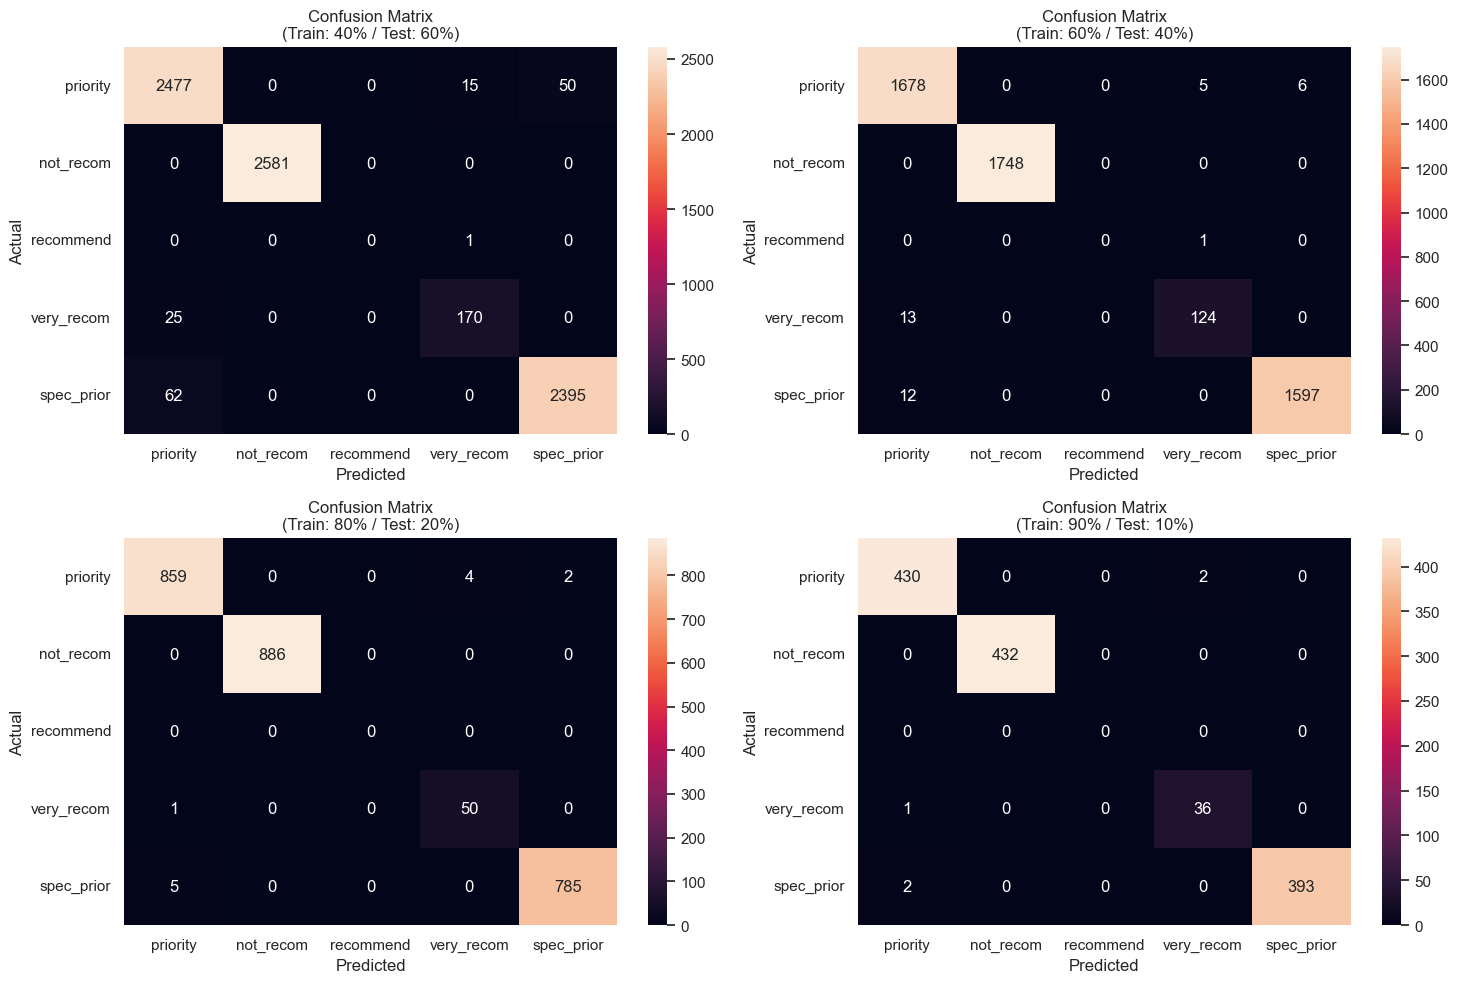

In [36]:
# Fit an instance of DecisionTreeClassifier to each training set
# Visualize the decision tree of each training set using graphviz
# Evaluate the performance of each decision tree on the test set using classification_report and confusion_matrix
build_and_evaluate_decision_tree(nursery_data, splited_data, proportions)

## The depth and accuracy of a decision tree

Max depth: None Accuracy score: 0.9953703703703703
Max depth: 2 Accuracy score: 0.7766203703703703
Max depth: 3 Accuracy score: 0.8198302469135802
Max depth: 4 Accuracy score: 0.8688271604938271
Max depth: 5 Accuracy score: 0.8823302469135802
Max depth: 6 Accuracy score: 0.8935185185185185
Max depth: 7 Accuracy score: 0.9239969135802469


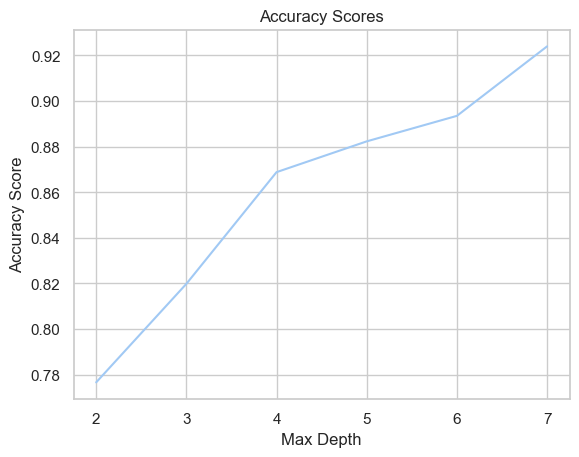

In [37]:
# use dataset 80% for training and 20% for testing
dataset = splited_data[2]
evaluate_depths_of_decision_tree(dataset)